In [1]:
# You must run this cell, but you can ignore its contents.

import hashlib

def ads_hash(ty):
    """Return a unique string for input"""
    ty_str = str(ty).encode()
    m = hashlib.sha256()
    m.update(ty_str)
    return m.hexdigest()[:10]

# transcriptome clustering analysis

In this exercise, you are going to analyze the results of an experiment in which the RNA was sequenced (a "transcriptome" was made) for many cells in cell culture. We expect that the total number of cell types is rather limited, although we sequenced many individual cells.

The data here is fake, but the analysis methods are real and are in heavy use across lots of different labs and can be applied to many other types of problems beyond RNA sequencing data.

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

We are given a dataset where the RNA expression levels of 50 genes from each of many cells was quantified. The data is in the file `RNAseq_data_50genes.csv`. Let's read this into a pandas DataFrame.

In [3]:
df = pd.read_csv('RNAseq_data_50genes.csv')

Now let's have a first look at this data.

In [4]:
df.head()

,gene 0,gene 1,gene 2,gene 3,gene 4,gene 5,gene 6,gene 7,gene 8,gene 9,...,gene 40,gene 41,gene 42,gene 43,gene 44,gene 45,gene 46,gene 47,gene 48,gene 49
0,2377,2886,1524,2235,2472,1256,1006,1902,911,2285,...,0,1115,1381,2226,1810,2124,1479,719,0,529
1,1251,948,3038,3857,1971,1761,2371,632,1705,2251,...,954,1874,527,1783,1922,1029,173,2267,1078,1343
2,2650,1643,1560,2545,1689,1072,1999,1707,579,1655,...,589,409,967,1762,1789,2424,494,1680,0,1283
3,1622,1581,1333,2218,2346,342,1534,1571,456,187,...,2535,1524,236,1343,1089,1429,930,1415,173,1153
4,1863,993,1225,1318,1854,0,1461,634,663,0,...,1882,1072,0,3040,1031,553,1468,2100,0,1001


## Q1 Understanding the raw data.

In the first row (with index 0), how many reads were made of gene 0? Put the answer in the variable `n_reads_sample0_gene0`.

In [5]:
# Type your answer here and then run this and the following cell.
n_reads_sample0_gene0 = 2377

In [6]:
# This is a test of the above, do not change this code.
assert type(n_reads_sample0_gene0)==int
assert ads_hash(n_reads_sample0_gene0)=='1a5de96b83'

How many total cells were sequenced? This is the number of rows in the dataframe. Put this in the variable `n_cells_sequenced`.

In [7]:
# Type your answer here and then run this and the following cell.
n_cells_sequenced = len(df)

In [8]:
# This is a test of the above, do not change this code.
assert type(n_cells_sequenced)==int
assert ads_hash(n_cells_sequenced)=='284b7e6d78'

How many genes do we have in our dataset? This is actually the dimensionality of our dataset. We are counting reads for each of these genes, so if we have N genes, we have an N dimensional dataset. Put your answer in the variable `n_dim`.

In [9]:
# Type your answer here and then run this and the following cell.
n_dim = 50

In [10]:
# This is a test of the above, do not change this code.
assert type(n_dim)==int
assert ads_hash(n_dim)=='1a6562590e'

## Quickly plotting pandas DataFrames with seaborn

Several lectures ago, we discussed seaborn we are are going to use it below to make a plot with our transcriptomic data. Let's first practice with a simple dataset:

,column 1,column 2
0,1,1
1,2,5
2,3,5
3,4,2
4,5,2


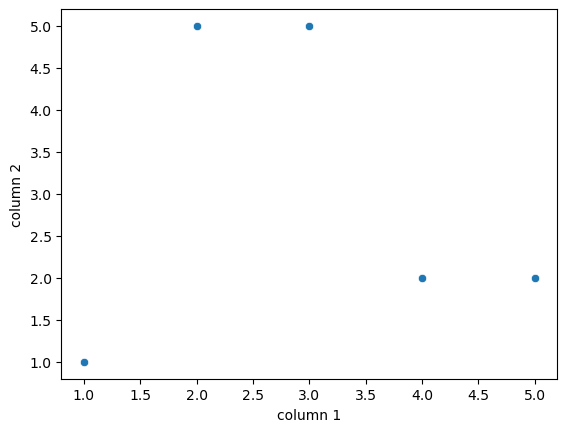

In [11]:
simple_df = pd.DataFrame(data={'column 1':[1,2,3,4,5], 'column 2':[1,5,5,2,2]})
display(simple_df)
sns.scatterplot(data=simple_df, x='column 1', y='column 2');

## Q2 Visualizing the raw data

Now let's use seaborn to make a quick plot of the data (stored as a Pandas DataFrame in the variable `df`). Use the seaborn `scatterplot` function to make a plot like the following. Your plot should include the X and Y axes labels. You need only a single line of code for this.

![scatterplot.png](scatterplot.png).

<Axes: xlabel='gene 0', ylabel='gene 1'>

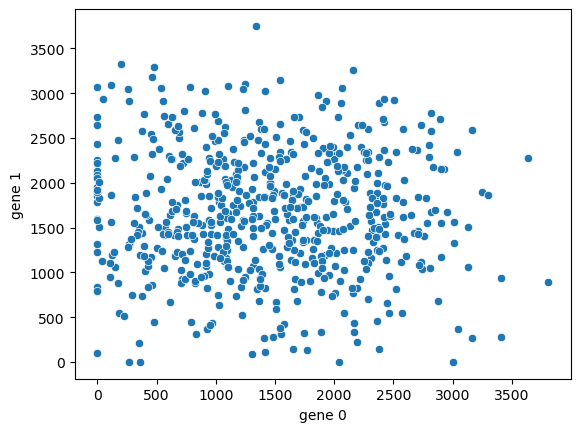

In [12]:
# Type your answer here. It should make a plot just like above.
sns.scatterplot(data=df, x='gene 0', y='gene 1')
# plt.savefig('scatterplot.png')

# first impressions of the data

So, how does our data look? At first glance it looks... like a bunch of random numbers with no real structure! But could there be some structure? For example, above we learned that although many cells have been sequenced, we expect these are from only a very limited number of cell types.

How can we figure out something about these cell types?

Let's make use of principal component analysis (PCA) and clustering from scikit-learn as some of the first tools in our toolkit.

## Converting to plain numpy

While Pandas is very convenient for many things, scikit learn uses plain numpy arrays and generally works best when the datatype is a floating point number rather than an integer. Let's do this conversion now and call our data `X`. (We also `copy()` this to a new numpy array to ensure it is contiguous in memory.)

In [13]:
X = df.to_numpy(dtype=np.float64).copy()

## PCA

Let's first run PCA on our data.

In [14]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)

The results of our analysis are stored in the variable `pca`. We can use this to project our original 50 dimensional data into its principle components and plot just the first two dimensions in this principle component space.

In [15]:
projected = pca.transform(X)

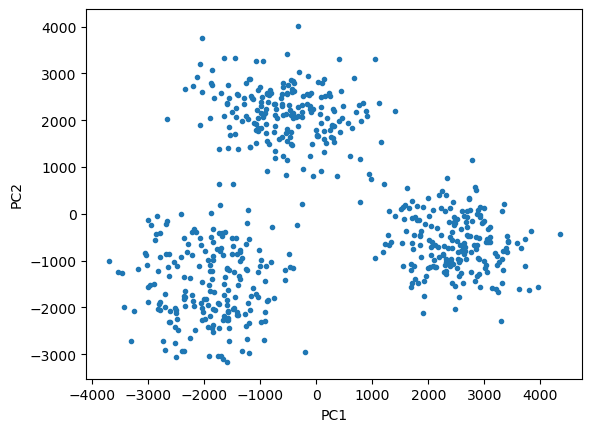

In [16]:
plt.plot(projected[:,0], projected[:,1],'.')
plt.xlabel('PC1')
plt.ylabel('PC2');

## Structure in the PCA space

Now, what do you notice about the data in this PCA space?

Now, instead of looking like a structure-free blob, we seem to have some structure. What kind of structure do we have?

"3 clusters", I hope you are thinking. Biologically speaking, we are now guessing that there were this many cell types in our original sample.

## PCA explained variance

One of the first questions about PCA is how much of the variance in our data are "explained" by the first N components of the projected data. Let's plot this.

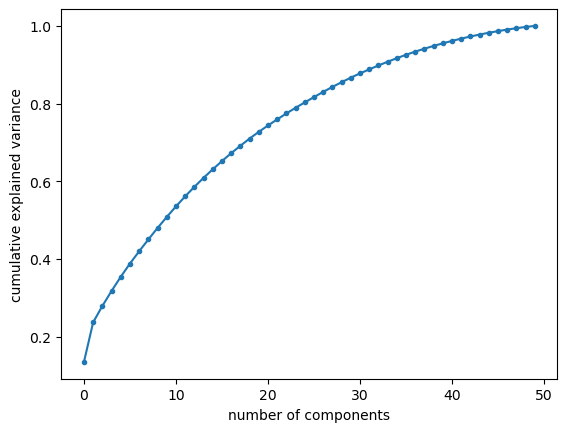

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## mini batch K-Means

Given that it looks like our data may have three clusters, let's find these clusters using mini batch K-Means.

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

## Q3. Specifying *k*, the number of clusters

As always, with a K-Means type algorithm, we must specify the number of clusters before running the algorithm. Use your thoughts from above and put this in the variable `n_clusters`.

In [19]:
# Type your answer here and then run this and the following cell.
n_clusters = 3

In [20]:
# This is a test of the above, do not change this code.
assert type(n_clusters)==int
assert ads_hash(n_clusters)=='4e07408562'

Now we are going to actually run the algorithm from scikit learn.

In [31]:
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=6, random_state=0, n_init='auto').fit(X);

## plotting the clustering results in the original "number of reads" space

Let's first plot the our raw read data in a scatter plot like above, but colored according to our cluster label. We will also plot our cluster centers here.

In [22]:
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

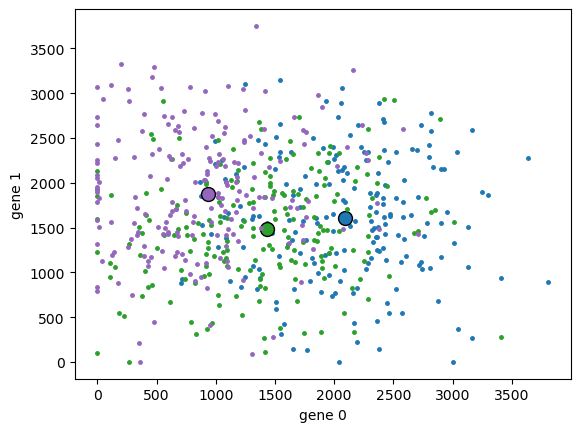

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)

x_gene_idx = 0
y_gene_idx = 1

for k in range(n_clusters):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    line, = ax.plot(X[my_members, x_gene_idx], X[my_members, 1], '.', markersize=5)
    ax.plot(cluster_center[x_gene_idx], cluster_center[1], 'o', markersize=10, markeredgecolor='black', markerfacecolor=line.get_color())
ax.set_xlabel('gene %d' % x_gene_idx)
ax.set_ylabel('gene %d' % y_gene_idx);

## plotting the clustering results in PCA space

Hmm, the plot above was not too informative. It does not seem to show obvious clusters in the data, and the points look very interwoven with others, at least for these two genes.

Let's re-plot our cluster assignments, but this time using the projection into PCA space.

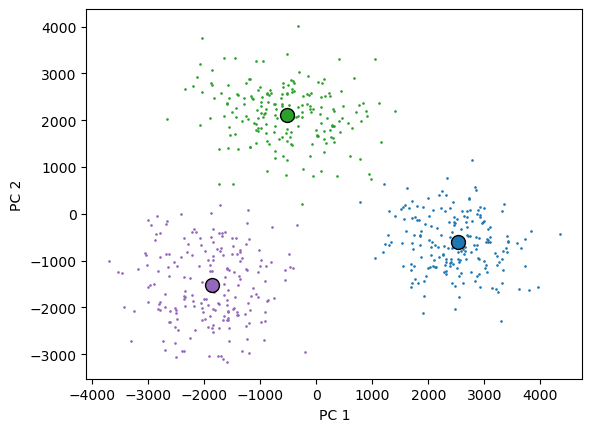

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)

projected_centers = pca.transform(mbk.cluster_centers_)

for k in range(n_clusters):
    my_members = mbk_means_labels == k
    projected_cluster_center = projected_centers[k]
    line, = ax.plot(projected[my_members, 0], projected[my_members, 1], '.',
                    markersize=1.8)
    ax.plot(projected_cluster_center[0], projected_cluster_center[1], 'o',
            markersize=10, markeredgecolor='black', markerfacecolor=line.get_color())
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2');

## silhouette analysis with K-means

OK, so that last plot (in PCA space) is looking better. The automatically detected clusters seem to agree with the idea we had from just looking at the data. Let's now use a silhouette analysis as one way to check whether this was a particularly good number of clusters for this data.

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.0869668556244729
For n_clusters = 3 The average silhouette_score is : 0.13476859870312252
For n_clusters = 4 The average silhouette_score is : 0.10835675894930853
For n_clusters = 5 The average silhouette_score is : 0.08364401842688216
For n_clusters = 6 The average silhouette_score is : 0.08246265485947758


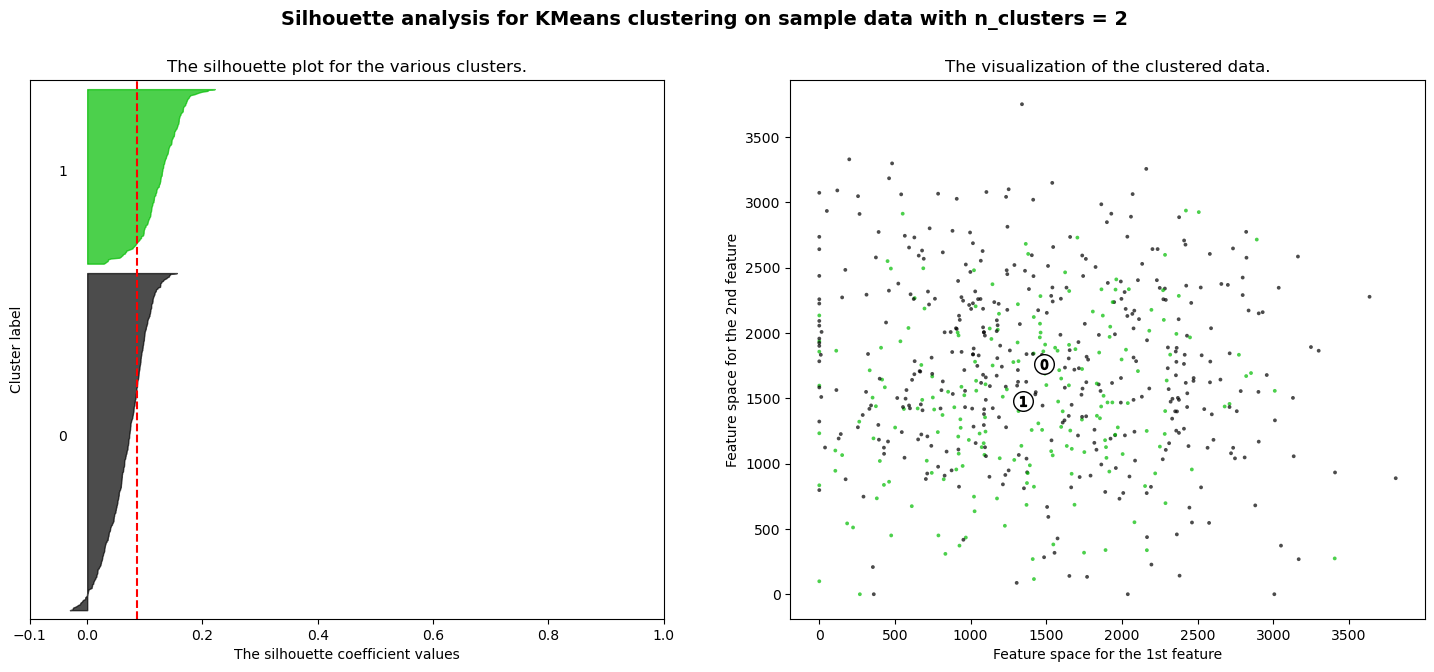

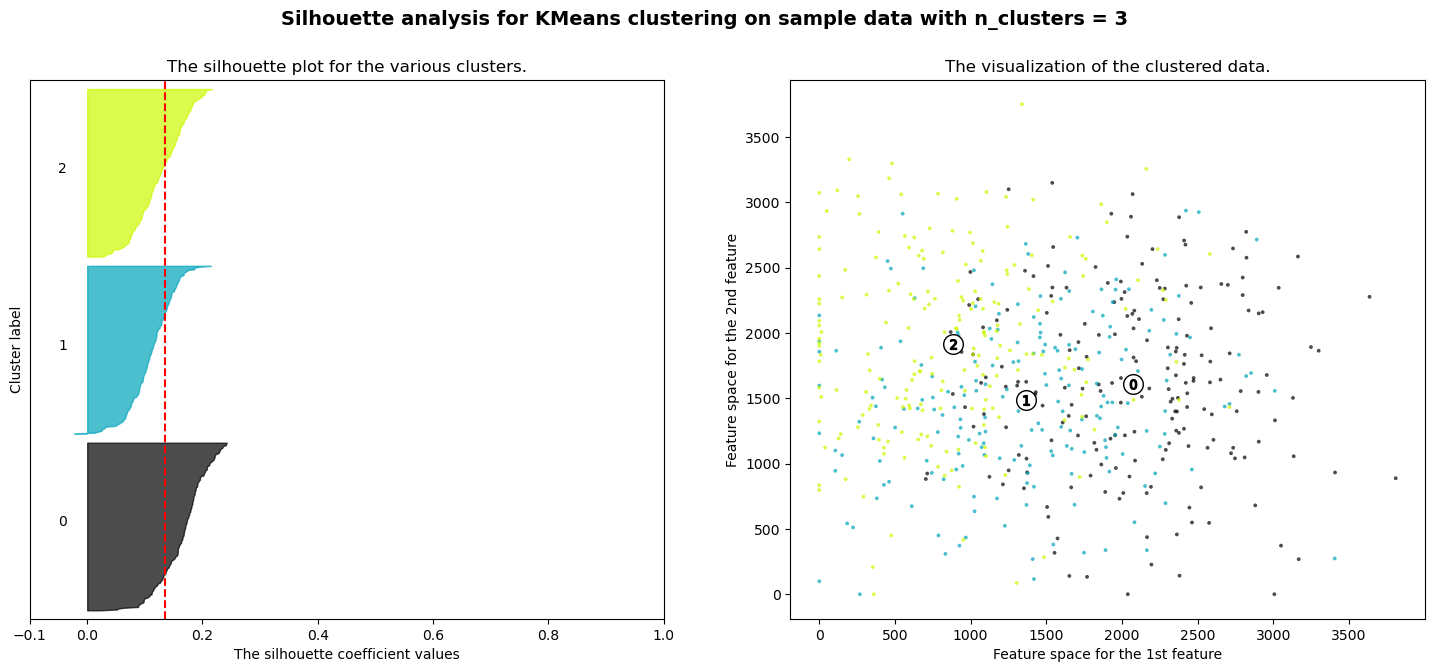

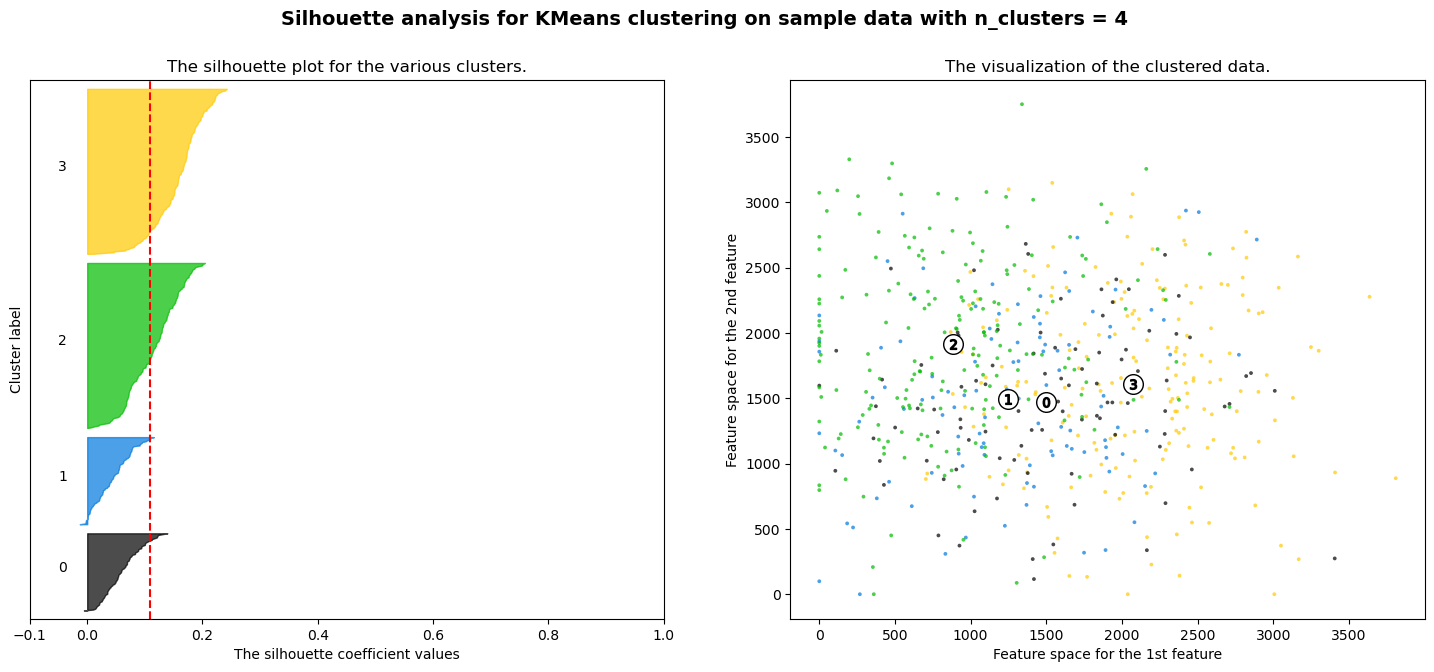

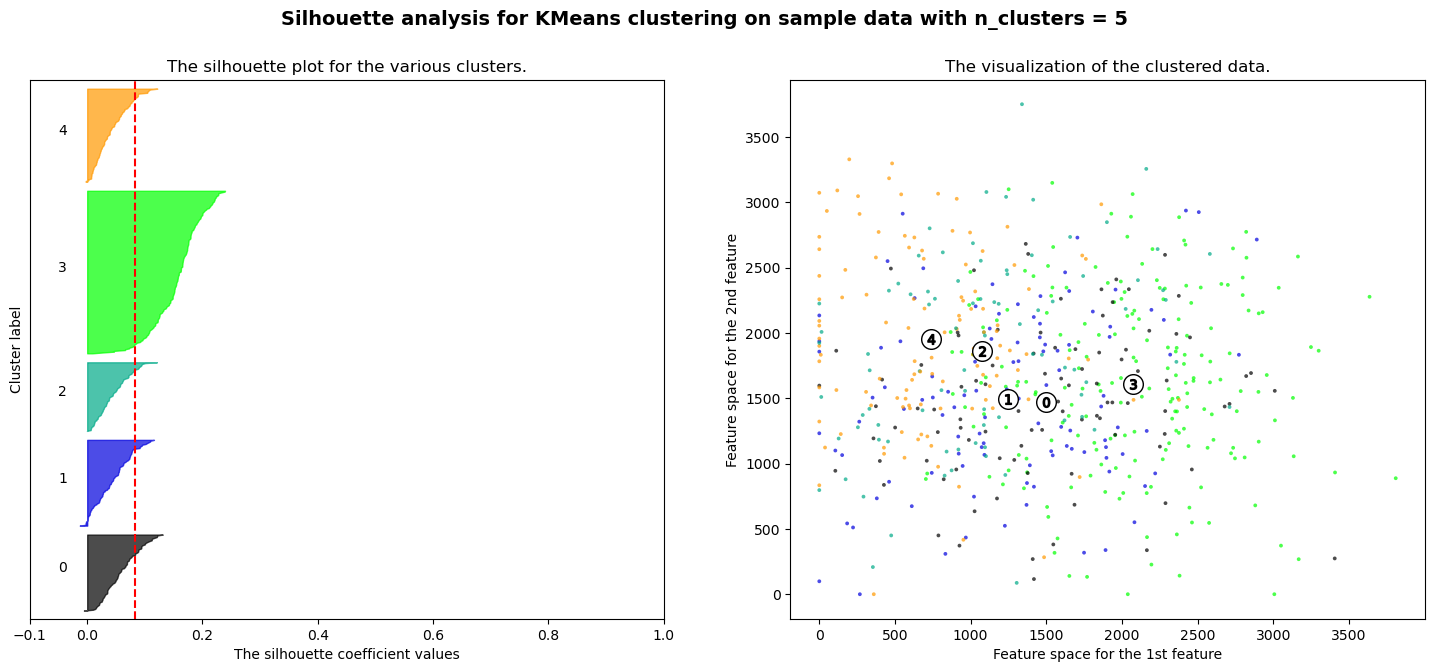

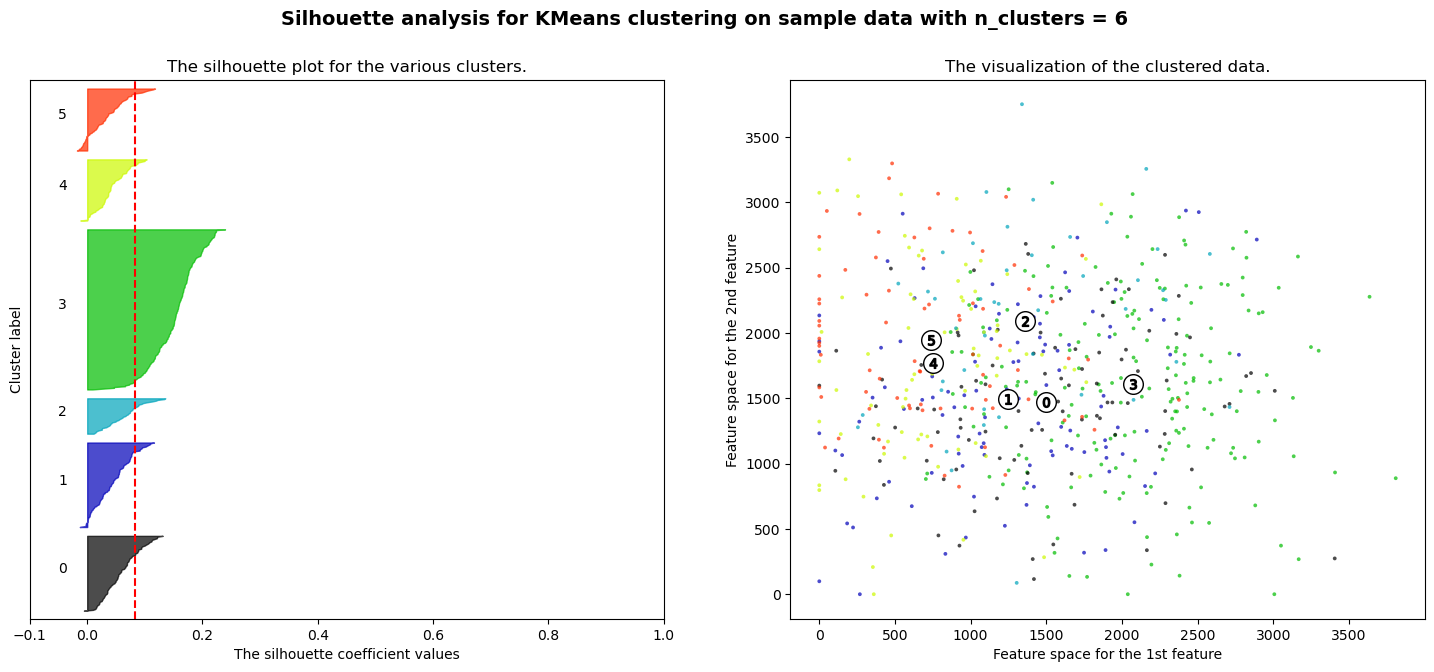

In [32]:
# From https://scikit-learn.org/0.21/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

So, the average silhouette score was highest for 3 clusters. So it looks like our "by eye" analysis also agrees with this analysis.

## agglomerative clustering

Now let's try a different form of clustering in which we do not need to set, in advance, the number of clusters.

This is *hierarchical agglomerative clustering*.

In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
from scipy.cluster.hierarchy import dendrogram

In [29]:
aggclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggclust.fit(X);

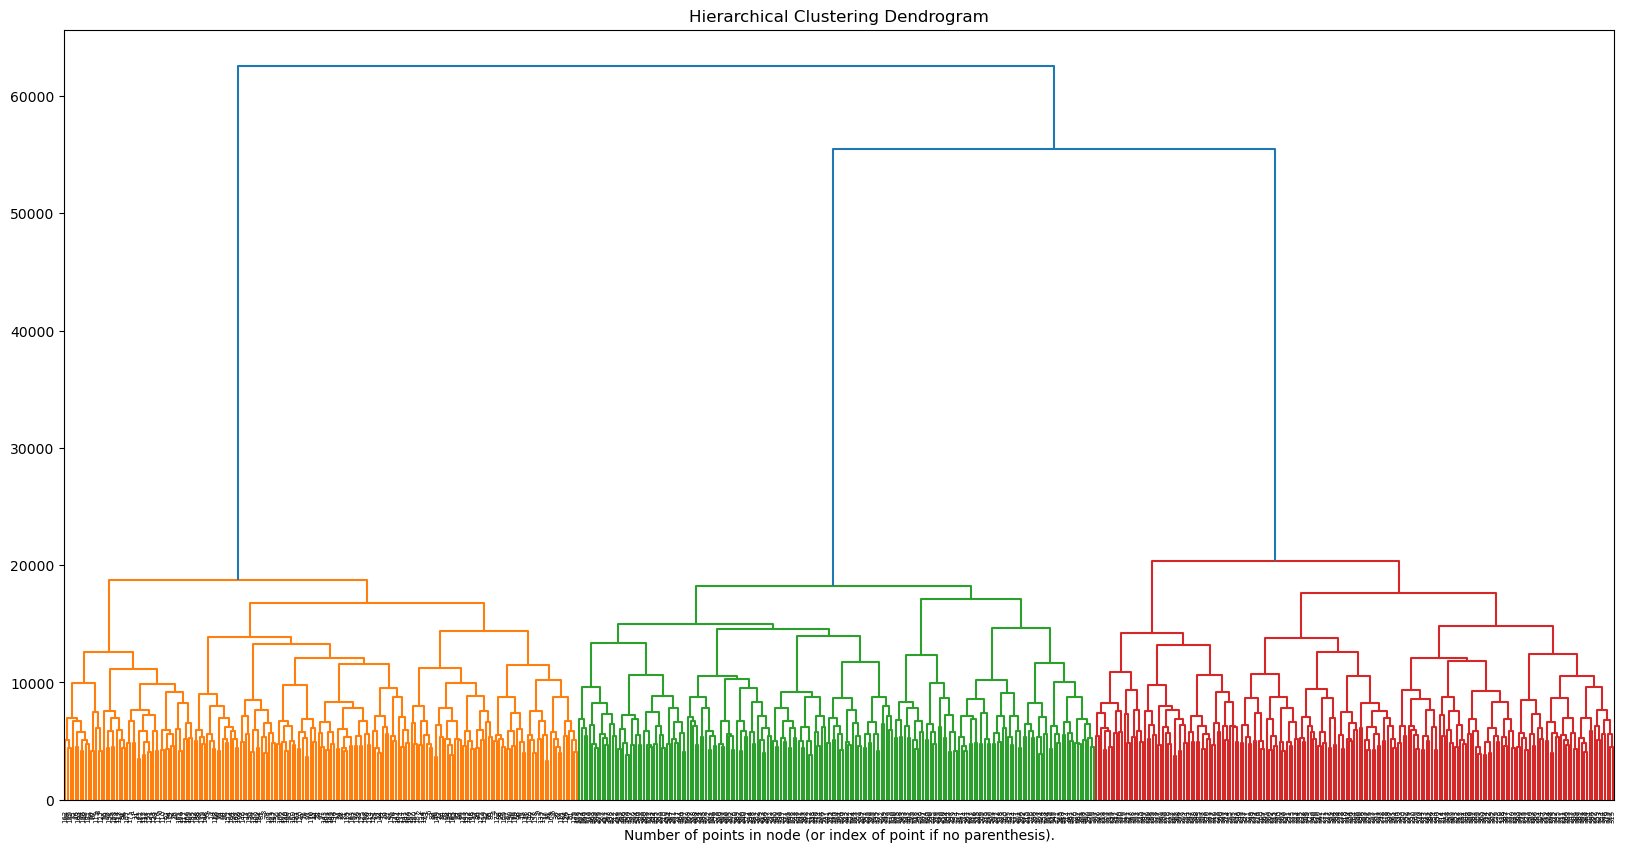

In [30]:
# Based on example at https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(aggclust)#, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).");

These dendrograms are often used in combination with a display of the gene expression data in a "heatmap".

Here is a single example of approximately zillions in the literature. The rows in the heatmap matrix are 1259 genes, the columns are different strains of bacteria.

![ofv09303.jpg](ofv09303.jpg)

Downloaded from [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4512144/) [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4512144/bin/ofv09303.jpg).


## Further thoughts and questions

- Does clustering before PCA work better or clustering after PCA?
- How would you judge this?
- As discussed in the lecture, PCA is a parameter-free, linear, very fast dimensionality reduction technique and is almost always the first dimensionality reduction technique you should try if you want to look at high dimensional data. If PCA doesn't perform well, there are many other techniques. PCA can give a good first intuition into dimensionality reduction as a broad class of techniques, which is why we do it here. Non-linear techniques in widespread use include ICA (independent component analysis), T-SNE (T stochastic neighbor embedding), and UMAP (Uniform Manifold Approximation and Projection).